# Deutsch-Jozsa Algorithm
The Deutsch-Jozsa algorithm is a quantum algorithm that solves the Deutsch problem. Given a function $f: \{0, 1\}^n \rightarrow \{0, 1\}$, the Deutsch problem is to determine whether $f$ is constant for all inputs or balanced i.e. returns 0 for half of the inputs and 1 for the other half. The classical solution to this problem needs in the worst case $2^{n-1} + 1$ queries to the function $f$. The Deutsch-Jozsa algorithm solves this problem with only one query to the function $f$.

## Simplification - Deutsch Algorithm
The Deutsch algorithm is a simplified version of the Deutsch-Jozsa algorithm and is a good starting point to understand the Deutsch-Jozsa algorithm. The Deutsch algorithm solves the Deutsch problem for the case where $n=1$. Since the implementation of the function $f$ needs to be reversible, $f$ is implemented as a unitary operator $U_f$, that acts on two qubits, the **data qubit** and the **target qubit**. The function $f$ is implemented as follows:
$$
U_f : \ket{x}\ket{y} \rightarrow \ket{x}\ket{y \oplus f(x)}
$$
where $\oplus$ denotes addition modulo 2.

In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.quantum_info import Statevector
from IPython.display import display
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

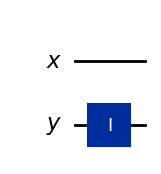

In [2]:
constant = True
constant_value = 0

x = QuantumRegister(1, 'x')
y = QuantumRegister(1, 'y')
oracle_qc = QuantumCircuit(x, y)

if constant:
    if constant_value:
        oracle_qc.x(y)
    else:
        oracle_qc.id(y)
else:
    oracle_qc.cx(x, y)
display(oracle_qc.draw('mpl'))

oracle_deutsch = oracle_qc.to_gate(label='$U_f$')

### Implementation
The first step of the Deutsch algorithm is to prepare the two qubits in the state $\ket{0}\ket{1}$:
$$
\ket{\psi_1} = \ket{0}\ket{1}
$$

In [3]:
qc_deutsch = QuantumCircuit(2, 1)
qc_deutsch.x(1)
qc_deutsch.barrier()
state = Statevector(qc_deutsch)
state.reverse_qargs().draw('latex', prefix='\\ket{\\psi_1} = ')

<IPython.core.display.Latex object>

The second step is to apply the Hadamard gate $H$ to both qubits, so that the state becomes:
$$
\begin{align*}
\ket{\psi_2} &= H^{\otimes 2}\ket{\psi_1} \\
&= \frac{1}{\sqrt{2}}(\ket{0} + \ket{1})\frac{1}{\sqrt{2}}(\ket{0} - \ket{1}) \\
&= \frac{1}{2}(\ket{0} \ket{0} - \ket{0} \ket{1} + \ket{1} \ket{0} - \ket{1} \ket{1})
\end{align*}

In [4]:
qc_deutsch.h([0, 1])
state = Statevector(qc_deutsch)
state.reverse_qargs().draw('latex', prefix='\\ket{\\psi_2} = ')

<IPython.core.display.Latex object>

Now, the Operator $U_f$ is applied to the state $\ket{\psi_2}$:
$$
\begin{align*}
\ket{\psi_3} &= U_f\ket{\psi_2} \\
&= \frac{1}{2}(U_f\ket{00} - U_f\ket{01} + U_f\ket{10} - U_f\ket{11}) \\
&= \frac{1}{2}(\ket{0, 0 \oplus f(0)} - \ket{0, 1 \oplus f(0)} + \ket{1, 0 \oplus f(1)} - \ket{1, 1 \oplus f(1)}) \\
&= \frac{1}{2}(\ket{0} \cdot (\ket{f(0)} - \ket{1 \oplus f(0)}) + \ket{1} \cdot (\ket{f(1)} - \ket{1 \oplus f(1)})) \\ 
&= \frac{1}{2} ((-1)^{f(0)}\ket{0}(\ket{0} - \ket{1}) + (-1)^{f(1)}\ket{1}(\ket{0} - \ket{1})) \\
&= \frac{1}{2} ((-1)^{f(0)}\ket{0} + (-1)^{f(1)}\ket{1})(\ket{0} - \ket{1})
\end{align*}
$$
If $f$ is constant, then $f(0) = f(1)$ and the state $\ket{\psi_3}$ becomes:
$$
\ket{\psi_3} = \frac{1}{2} (\pm (\ket{0} + \ket{1}))(\ket{0} - \ket{1})
$$
If $f$ is balanced, then $f(0) \neq f(1)$ and the state $\ket{\psi_3}$ becomes:
$$
\ket{\psi_3} = \frac{1}{2} (\pm (\ket{0} - \ket{1}))(\ket{0} - \ket{1})
$$

In [5]:
qc_deutsch.append(oracle_deutsch, [0, 1])
qc_deutsch.barrier()

CircuitInstruction(operation=Instruction(name='barrier', num_qubits=2, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(2, 'q'), 0), Qubit(QuantumRegister(2, 'q'), 1)), clbits=())

In the last step, the Hadamard gate $H$ is applied to the first qubit, resulting in the state for the constant function:
$$
\ket{\psi_4} = \pm \ket{0} \left( \frac{\ket{0} - \ket{1}}{\sqrt{2}} \right)
$$
and for the balanced function:
$$
\ket{\psi_4} = \pm \ket{1} \left( \frac{\ket{0} - \ket{1}}{\sqrt{2}} \right)
$$
This can be simplified to:
$$
\ket{\psi_4} = \pm \ket{f(0) \oplus f(1)} \left( \frac{\ket{0} - \ket{1}}{\sqrt{2}} \right)
$$
By measuring the first qubit, the function $f$ can be determined. If the function is constant, the first qubit will be in the state $\ket{0}$ and if the function is balanced, the first qubit will be in the state $\ket{1}$.

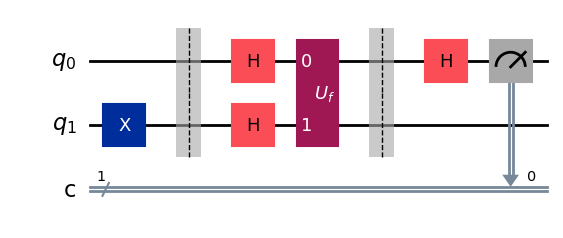

In [6]:
qc_deutsch.h(0)
qc_deutsch.measure(0, 0)
qc_deutsch.draw('mpl')

### Simulation

In [7]:
simulator = AerSimulator()
shots = 1024
sim_result_deutsch = simulator.run(qc_deutsch.decompose(), shots=shots).result()

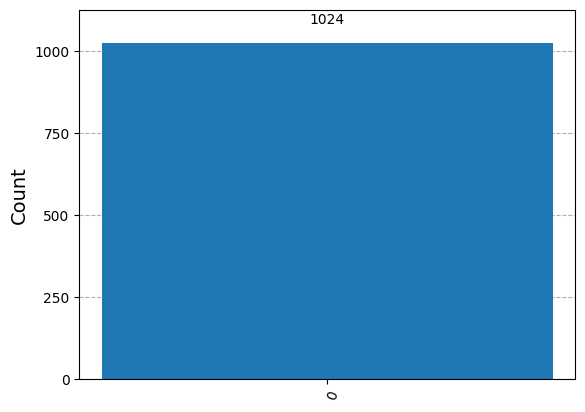

The function is constant


In [8]:
counts_d = sim_result_deutsch.get_counts()
display(plot_histogram(counts_d))
if '0' in counts_d and counts_d['0'] == shots:
    print('The function is constant')
elif '1' in counts_d and counts_d['1'] == shots:
    print('The function is balanced')
else:
    print('Error') 

## Deutsch-Jozsa Algorithm
The Deutsch-Jozsa algorithm generalizes the Deutsch algorithm to the case where $n > 1$. Again, the function $f$ is implemented as a unitary operator $U_f$ that acts on $n+1$ qubits, the **data qubits** $\ket{x}$ and the **target qubit** $\ket{y}$
$$
U_f : \ket{x}\ket{y} \rightarrow \ket{x}\ket{y \oplus f(x)}
$$

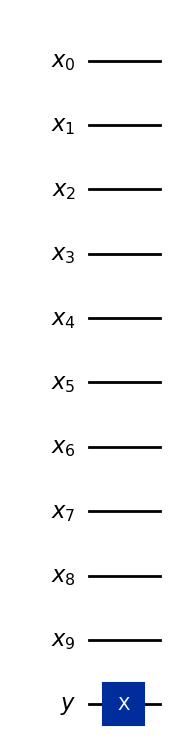

In [9]:
# Settings
n_qubits = 10
constant = True
constant_value = 1

# Set up quantum circuit
x = QuantumRegister(n_qubits, 'x')
y = QuantumRegister(1, 'y')
oracle_qc = QuantumCircuit(x, y)

# Create the oracle
if constant:
    if constant_value:
        oracle_qc.x(y)
else:
    for qubit in range(n_qubits):
        oracle_qc.cx(x[qubit], y)

display(oracle_qc.draw('mpl'))
oracle_deutsch_jozsa = oracle_qc.to_gate(label='$U_f$')

### Implementation
As with the Deutsch algorithm, the first step is to prepare the state:
$$
\ket{\psi_0} = \ket{0}^{\otimes n}\ket{1}
$$

In [10]:
c = ClassicalRegister(n_qubits, 'c')
qc_deutsch_jozsa = QuantumCircuit(x, y, c)
qc_deutsch_jozsa.x(y)
qc_deutsch_jozsa.barrier()

CircuitInstruction(operation=Instruction(name='barrier', num_qubits=11, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(10, 'x'), 0), Qubit(QuantumRegister(10, 'x'), 1), Qubit(QuantumRegister(10, 'x'), 2), Qubit(QuantumRegister(10, 'x'), 3), Qubit(QuantumRegister(10, 'x'), 4), Qubit(QuantumRegister(10, 'x'), 5), Qubit(QuantumRegister(10, 'x'), 6), Qubit(QuantumRegister(10, 'x'), 7), Qubit(QuantumRegister(10, 'x'), 8), Qubit(QuantumRegister(10, 'x'), 9), Qubit(QuantumRegister(1, 'y'), 0)), clbits=())

Next, the Hadamard gate $H$ is applied to all qubits, leaving the input qubits in a superposition of all possible numbers from $0$ to $2^n - 1$ (in binary representation) and the target qubit in the bell state $\ket{-}$
$$
\begin{align*}
\ket{\psi_1} &= H^{\otimes n+1}\ket{\psi_0} \\
&= \sum_{x=0}^{2^n-1} \frac{1}{2^{n/2}}\ket{x}\left(\frac{\ket{0} - \ket{1}}{\sqrt{2}}\right)
\end{align*}
$$

In [11]:
qc_deutsch_jozsa.h(x)
qc_deutsch_jozsa.h(y)

Now, the operator $U_f$ is applied to the state $\ket{\psi_1}$:
$$
\begin{align*}
\ket{\psi_2} &= U_f\ket{\psi_1} \\
&= \sum_{x=0}^{2^n-1} \frac{1}{2^{n/2}}\ket{x}\left(\frac{\ket{f(x)} - \ket{1 \oplus f(x)}}{\sqrt{2}}\right) \\
&= \sum_{x=0}^{2^n-1} \frac{(-1)^{f(x)}}{2^{n/2}}\ket{x}\left(\frac{\ket{0} - \ket{1}}{\sqrt{2}}\right)
\end{align*}
$$

In [12]:
qc_deutsch_jozsa.append(oracle_deutsch_jozsa, x[:] + y[:])
qc_deutsch_jozsa.barrier()

CircuitInstruction(operation=Instruction(name='barrier', num_qubits=11, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(10, 'x'), 0), Qubit(QuantumRegister(10, 'x'), 1), Qubit(QuantumRegister(10, 'x'), 2), Qubit(QuantumRegister(10, 'x'), 3), Qubit(QuantumRegister(10, 'x'), 4), Qubit(QuantumRegister(10, 'x'), 5), Qubit(QuantumRegister(10, 'x'), 6), Qubit(QuantumRegister(10, 'x'), 7), Qubit(QuantumRegister(10, 'x'), 8), Qubit(QuantumRegister(10, 'x'), 9), Qubit(QuantumRegister(1, 'y'), 0)), clbits=())

The Hadamard gate $H$ is applied to the input qubits:
$$
\begin{align*}
\ket{\psi_3} &= H^{\otimes n}\ket{\psi_2} \\
&= \sum_{x=0}^{2^n-1} \frac{(-1)^{f(x)}}{2^{n/2}} H^{\otimes n}(\ket{x})\left(\frac{\ket{0} - \ket{1}}{\sqrt{2}}\right) \\
&= \sum_{x=0}^{2^n-1} \frac{(-1)^{f(x)}}{2^{n/2}} \frac{1}{2^{n/2}}\sum_{z=0}^{2^n-1} (-1)^{x \cdot z}\ket{z}\left(\frac{\ket{0} - \ket{1}}{\sqrt{2}}\right) \\
&= \left(\frac{1}{2^n}\sum_{z=0}^{2^n-1} \sum_{x=0}^{2^n-1} (-1)^{f(x) + x \cdot z}\ket{z}\right) \left(\frac{\ket{0} - \ket{1}}{\sqrt{2}}\right)
\end{align*}
$$

Now, the data qubits are measured. The probability of measuring the state $\ket{z} = \ket{0}^{\otimes n}$ is:
$$
\left| \frac{1}{2^n}\sum_{x=0}^{2^n-1} (-1)^{f(x)} \right|^2
$$
If $f$ is constant, then the probability is
$$
\begin{align*}
\left| \frac{1}{2^n}\sum_{x=0}^{2^n-1} (-1)^{f(x)} \right|^2 &= \left| \frac{1}{2^n}\sum_{x=0}^{2^n-1} (-1)^c \right|^2 \\
&= \left| \frac{1}{2^n}2^n(-1)^c \right|^2 \\
&= 1
\end{align*}
$$
If $f$ is balanced, then the probability is $0$ since one half of the terms result in $1$ and the other half in $-1$.
In other words, if the state $\ket{0}^{\otimes n}$ is measured, the function $f$ is constant and if any other state is measured, the function $f$ is balanced.

In [13]:
qc_deutsch_jozsa.h(x)
qc_deutsch_jozsa.measure(x, c)

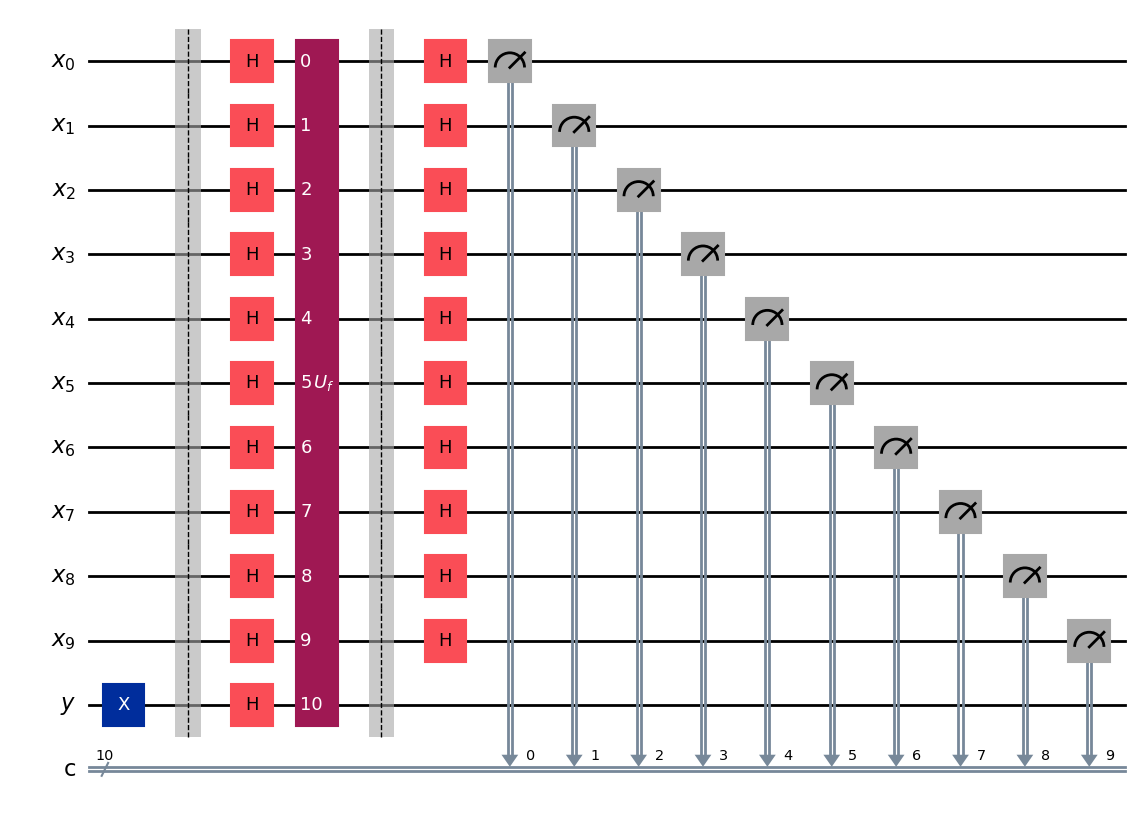

In [14]:
qc_deutsch_jozsa.draw('mpl')

### Simulation

In [15]:
simulator = AerSimulator()
shots = 4096
sim_result_dj = simulator.run(qc_deutsch_jozsa.decompose(), shots=shots).result()

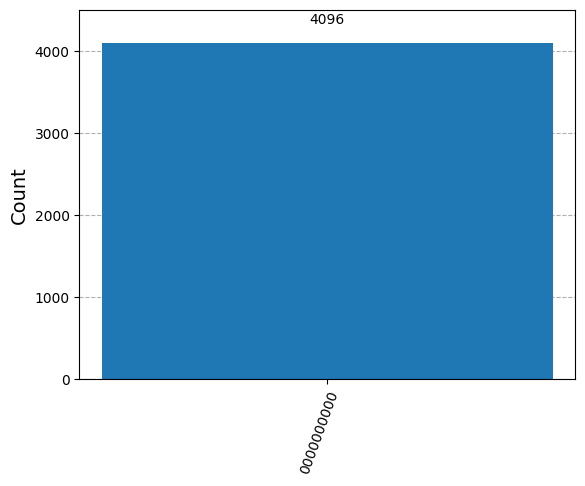

The function is constant


In [16]:
counts_dj = sim_result_dj.get_counts()
display(plot_histogram(counts_dj))
if '0'*n_qubits in counts_dj:
    print('The function is constant')
else:
    print('The function is balanced')

### Running on a Quantum Computer

In [17]:
service = QiskitRuntimeService()

# Get backend
backend = service.least_busy(operational=True, simulator=False, min_num_qubits=n_qubits)

In [18]:
# Transpile the circuit
pm = generate_preset_pass_manager(optimization_level=1, backend=backend)
qc_deutsch_jozsa_transpiled = pm.run(qc_deutsch_jozsa)

In [ ]:
sampler = Sampler(mode=backend)
job = sampler.run([qc_deutsch_jozsa_transpiled], shots=shots)
print(f">>> Job ID: {job.job_id()}")

#### Job with balanced function and 10 qubits

In [19]:
job_balanced = service.job('cv64xkyfkm5g008bys90')
result_balanced = job_balanced.result()

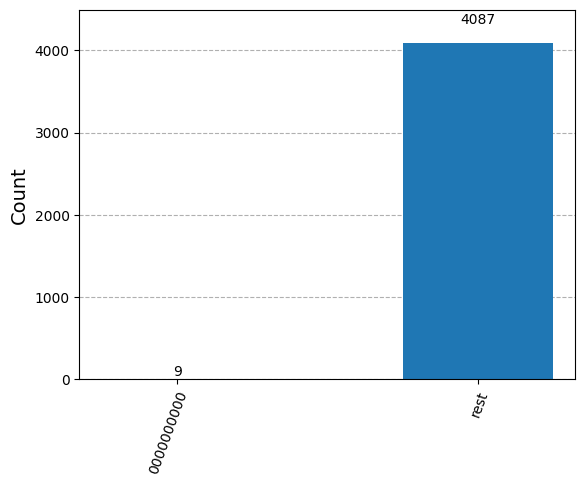

The function is balanced


In [20]:
counts_dj_ibm = result_balanced[0].data.c.get_counts()
aggregated_counts = {'rest': sum([v for k, v in counts_dj_ibm.items() if k != '0'*n_qubits])}
aggregated_counts['0'*n_qubits] = counts_dj_ibm['0'*n_qubits]
display(plot_histogram(aggregated_counts))
if aggregated_counts['0'*n_qubits] < aggregated_counts['rest']:
    print('The function is balanced')
else:
    print('The function is constant')

#### Job with constant function and 10 qubits

In [21]:
job_const = service.job('cv66tbhqxmm00085h7qg')
result_const = job_const.result()

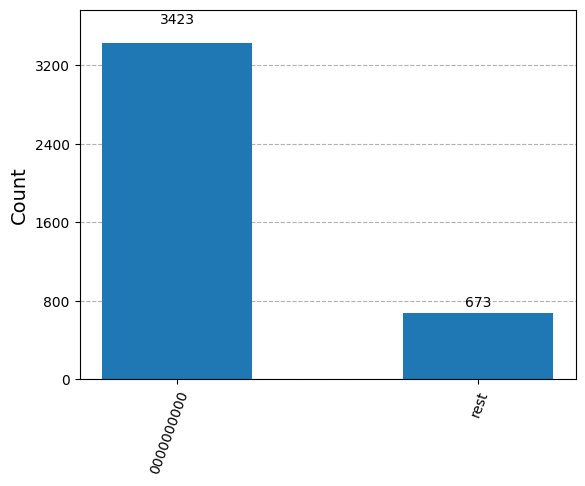

The function is constant


In [22]:
counts_dj_ibm_const = result_const[0].data.c.get_counts()
aggregated_counts_const = {'rest': sum([v for k, v in counts_dj_ibm_const.items() if k != '0'*n_qubits])}
aggregated_counts_const['0'*n_qubits] = counts_dj_ibm_const['0'*n_qubits]
display(plot_histogram(aggregated_counts_const))
if aggregated_counts_const['0'*n_qubits] < aggregated_counts_const['rest']:
    print('The function is balanced')
else:
    print('The function is constant')